In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
from scipy.io import loadmat
import os
import tensorflow as tf
import tensorflow_probability as tfp
np.set_printoptions(precision=3, suppress=True)

2024-02-26 13:49:07.592887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def convert_params_tf(params): 
    ''' 
    lambda, gamma, mu, c, b, sigma_d, sigma_p 
    '''
    c = params[3] 
    J = tf.gather(params, [0, 2, 0, 1])
    J = tf.tensor_scatter_nd_update(J, [[2]], [J[2]*c])
    J = tf.reshape(J, (2, 2))
    B = tf.linalg.diag(params[5:]**2)
    B = tf.tensor_scatter_nd_update(B, [[1, 1]], [B[1, 1] + B[0, 0]*c*c])
    B = tf.tensor_scatter_nd_update(B, [[1, 0]], [B[0, 0]*c])
    B = tf.tensor_scatter_nd_update(B, [[0, 1]], [B[0, 1]])
    return J, B

def convert_params(params): 
    ''' 
    lambda, gamma, mu, c, b, sigma_d, sigma_p 
    '''
    c = params[3] 
    J = np.array([[params[0], params[2]], [params[0]*c, params[1]]])
    B = np.diagflat(params[5:])**2 
    B[1, 1] += c*c*B[0, 0] 
    B[1, 0] = c*B[0, 0]
    B[0, 1] = B[1, 0] 
    return J, B 

In [3]:
class nonlinear_model(): 
    
    def __init__(self, params):
        self.J, B = convert_params(params)
        self.b = params[4]
        self.rv =  multivariate_normal([0, 0], B)
        
    def evolve(self, T, dt, n_frames, n_repeats):
        results = [] 
        for n in range(n_repeats): 
            y = np.zeros((2))
            res = np.zeros((n_frames, 2))
            for i in range(n_frames):
                for j in range(int(T/n_frames/dt)):
                    self._update(y, dt)
                res[i] = np.copy(y)
            results.append(res.T) 
        return results 


    def _update(self, y, dt):
        det = self.J @ y 
        det[1] -= self.b * det[0]**3 
        sto = np.sqrt(dt)*self.rv.rvs()
        y += det*dt + sto 
        

In [121]:
class inference():
    
    def __init__(self):
        pass 
    
    def inf(self, guess, trajs, dt, n_steps=100, lr=0.01): 

        params = tf.Variable(guess)
        upper_bounds = tf.constant([0, 0, 1e5, 1e5, 1e5, 1e5, 1e5])
        lower_bounds = tf.constant([-1e5, -1e5, 0, 0, 0, 0, 0])

        optimizer = tf.optimizers.RMSprop(lr)
        
        for step in range(n_steps):
            with tf.GradientTape() as tape:
                loss = self._minuslogP(params, trajs, dt) 
                loss += self._penalty(params, lower_bounds, upper_bounds)
            gradients = tape.gradient(loss, [params])
            optimizer.apply_gradients(zip(gradients, [params]))

        MAP = params.numpy()
        cost = self._minuslogP(params, trajs, dt).numpy()
        return MAP, cost

    def inf2(self, guess, trajs, dt): 
        
        upper_bounds = tf.constant([0, 0, 1e5, 1e5, 1e5, 1e5, 1e5])
        lower_bounds = tf.constant([-1e5, -1e5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5])
        params = tf.constant(guess)

        cost = lambda x: self._minuslogP(x, trajs, dt) + self._penalty(x, lower_bounds, upper_bounds)
        quadratic_loss_and_gradient = lambda x: tfp.math.value_and_gradient(cost, x) 
        results = tfp.optimizer.bfgs_minimize(
                      quadratic_loss_and_gradient,
                      initial_position=tf.constant(guess),
                      tolerance=1e-5)
        MAP = params.numpy()
        cost = self._minuslogP(params, trajs, dt).numpy()
        return MAP, cost

    def _penalty(self, params, lower_bounds, upper_bounds): 
        penalty = 1e6*tf.maximum(0.0, lower_bounds - params)**2  # Penalize below lower bound
        penalty += 1e6*tf.maximum(0.0, params - upper_bounds)**2  # Penalize above upper bound
        return tf.reduce_sum(penalty)
           
    def _minuslogP(self, params, trajs, dt):
        '''
        traj: 2 x T 
        '''
        J, B = convert_params_tf(params)
        b = params[4]
        tril = tf.linalg.cholesky(B*dt)
        
        minuslogp = tf.constant(0.) 
        for traj in trajs: 
            dx = traj[:, 1:] - traj[:, :-1]
            det = J @ traj[:, :-1]
            det = tf.tensor_scatter_nd_update(det, [[1]], [det[1] - b * det[0]**3])
            dist = tfp.distributions.MultivariateNormalTriL(loc=tf.transpose(det)*dt, scale_tril=tril)
            minuslogp = minuslogp - tf.reduce_sum(dist.log_prob(dx.T))
        return minuslogp

### First, we make some simulations with known parameters and infer them with both inference methods

In [48]:
# params in order of [epsilon, gamma-mu*c, mu, c]
T = 100
dt = 5e-3
n_frames = int(20*T) 
n_repeats = 3

#  lambda, gamma, mu, c, b, sigma_d, sigma_p  
params = [-0.01, -0.1, 0.5, 0.1, 1, 0.1, 0.33]
J, B = convert_params(params)
print(J)
print(B)
print(np.linalg.eigvals(J))

m = nonlinear_model(params)
results = m.evolve(T, dt, n_frames, n_repeats)

[[-0.01   0.5  ]
 [-0.001 -0.1  ]]
[[0.01  0.001]
 [0.001 0.109]]
[-0.016 -0.094]


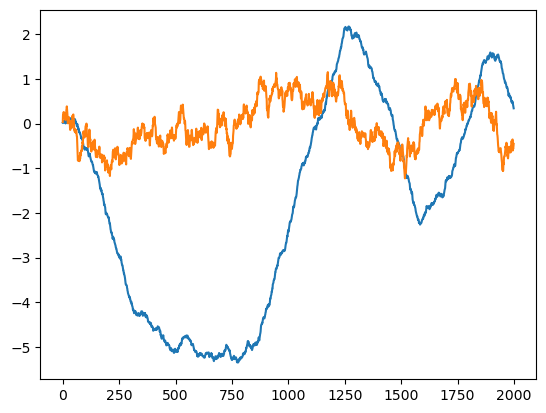

In [49]:
plt.plot(results[0][0])
plt.plot(results[0][1])
plt.show()

In [126]:
## Numerical inference with constraints 

inf = inference()

lb = tf.constant([-1e4, -1e4, 0, 0, 0, 0, 0])
ub = tf.constant([0, 0, 1e4, 1e4, 1e4, 1e4, 1e4])
true_params = tf.constant(params)
cost_true = inf._minuslogP(true_params, results, T/n_frames).numpy() + inf._penalty(true_params, lb, ub).numpy()
print('true params:', params, cost_true)

guess = [-1, -1, 0.5, 0.1, 1, 1, 1]
MAP, cost = inf.inf(guess, results, T/n_frames, n_steps=100, lr=0.05)
print('MAP: ', MAP, cost)

true params: [-0.01, -0.1, 0.5, 0.1, 1, 0.1, 0.33] -21416.105
MAP:  [-0.264 -0.142  0.655  0.313  0.268  1.448  0.769] -5604.8604


In [7]:
path = 'Data/N11_ThetaPola_DATA/'
files = [f for f in os.listdir(path) if f.endswith('mat')]
files.sort() # sort files so the polarization and theta are right next to each other in the list 

for element1, element2 in zip(files[::2], files[1::2]):
    print(f"{element1:} {element2:}")

theta_trajs = [] 
pol_trajs = []

for f in files: 
    if f.endswith('POLARIZATION.mat'):
        pol_trajs.append(loadmat(path+f)['POLA'])
    else: 
        theta_trajs.append(loadmat(path+f)['THETAd'])

N11_1_R200_B30_04_05_POLARIZATION.mat N11_1_R200_B30_04_05_ThetaTime.mat
N11_1_R200_B50_04_05_POLARIZATION.mat N11_1_R200_B50_04_05_ThetaTime.mat
N11_1_R200_B50_25_04_POLARIZATION.mat N11_1_R200_B50_25_04_ThetaTime.mat
N11_1_R200_B50_26_04_POLARIZATION.mat N11_1_R200_B50_26_04_ThetaTime.mat
N11_2_R200_B50_26_04_POLARIZATION.mat N11_2_R200_B50_26_04_ThetaTime.mat
N11_3_R200_B50_25_04_POLARIZATION.mat N11_3_R200_B50_25_04_ThetaTime.mat
N11_4_R200_B100_25_04_POLARIZATION.mat N11_4_R200_B100_25_04_ThetaTime.mat
N11_4_R200_B30_25_04_POLARIZATION.mat N11_4_R200_B30_25_04_ThetaTime.mat
N11_4_R200_B50_25_04_POLARIZATION.mat N11_4_R200_B50_25_04_ThetaTime.mat
N11_5_R200_B30_25_04_POLARIZATION.mat N11_5_R200_B30_25_04_ThetaTime.mat
N11_5_R200_B50_25_04_POLARIZATION.mat N11_5_R200_B50_25_04_ThetaTime.mat


In [8]:
print(list(map(len, theta_trajs)))
print(list(map(len, pol_trajs)))

[print(theta[0, 0], p[0, 0]) for (theta, p) in zip(theta_trajs, pol_trajs) ]

theta_trajs.pop(2)
pol_trajs.pop(2)


[5000, 5000, 2450, 5000, 5000, 3000, 5000, 5000, 5000, 1300, 5000]
[5000, 5000, 2400, 5000, 5000, 3000, 5000, 5000, 5000, 1300, 5000]
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333


array([[ 0.033,  0.247, -0.382, -0.725],
       [ 0.067,  0.103, -0.33 , -0.682],
       [ 0.1  , -0.053, -0.41 , -0.752],
       ...,
       [79.933,  0.564,  0.366, -0.558],
       [79.967,  0.572,  0.364, -0.619],
       [80.   ,  0.556,  0.398, -0.725]])

In [9]:
print(list(map(np.shape, theta_trajs)))
print(list(map(np.shape, pol_trajs)))
print([(theta[1, 0], p[1, 0]) for (theta, p) in zip(theta_trajs, pol_trajs)])
dt = theta_trajs[0][0, 0]
print('dt = ', dt)

[(5000, 2), (5000, 2), (5000, 2), (5000, 2), (3000, 2), (5000, 2), (5000, 2), (5000, 2), (1300, 2), (5000, 2)]
[(5000, 4), (5000, 4), (5000, 4), (5000, 4), (3000, 4), (5000, 4), (5000, 4), (5000, 4), (1300, 4), (5000, 4)]
[(0.06666666666666667, 0.06666666666666667), (0.06666666666666667, 0.06666666666666667), (0.06666666666666667, 0.06666666666666667), (0.06666666666666667, 0.06666666666666667), (0.06666666666666667, 0.06666666666666667), (0.06666666666666667, 0.06666666666666667), (0.06666666666666667, 0.06666666666666667), (0.06666666666666667, 0.06666666666666667), (0.06666666666666667, 0.06666666666666667), (0.06666666666666667, 0.06666666666666667)]
dt =  0.03333333333333333


In [10]:
f1 = lambda x: (x[:, 1] - np.mean(x[:, 1]))/180*np.pi
f2 = lambda x: np.mean(x[:, 1:4], axis=1) - np.mean(x[:, 1:4])
f3 = lambda x: x[:, 2] - np.mean(x[:, 2])

data = [np.stack([f1(theta), f3(p)]) for (theta, p) in zip(theta_trajs, pol_trajs)]

# for d in data: 
#     plt.plot(d[1], label='p')
#     plt.plot(d[0], label='theta')
#     plt.legend()
#     plt.show()

In [28]:
guess = [0.089, 2.537, 0.176, 3.574, 0, 0.025, 0.787]
bounds = [[0, None]]*7 
inf = inference()
MAP, y = inf.inf(guess, data, dt, bounds=bounds)
print(MAP, y)
print(guess, inf._minuslogP(guess, data, dt))

NameError: name 'data' is not defined

In [12]:
J, B = convert_params(MAP)
print(J)
print(B) 
print(np.linalg.eigvals(J))

[[-0.046  0.169]
 [-0.272 -1.41 ]]
[[0.001 0.004]
 [0.004 0.576]]
[-0.081 -1.376]


In [13]:
n_frames = 5000
m = nonlinear_model(MAP)
n_repeats = 5
sims = m.evolve(n_frames*dt, 5e-3, n_frames, n_repeats)

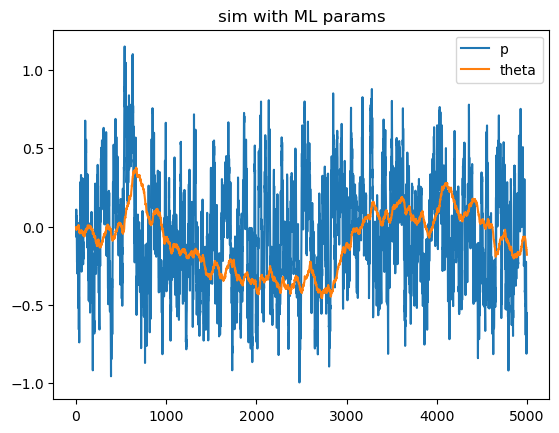

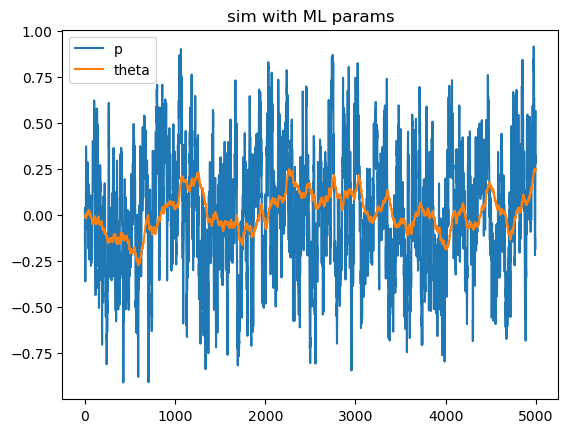

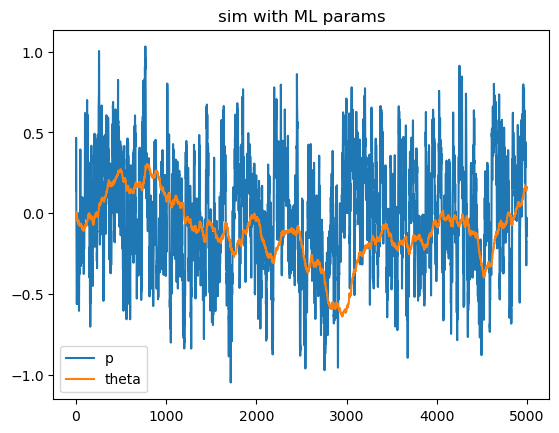

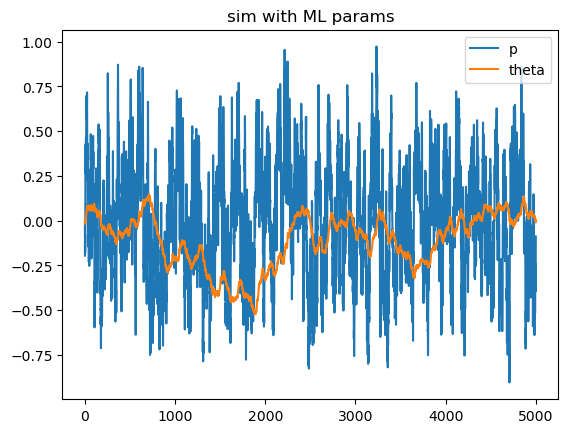

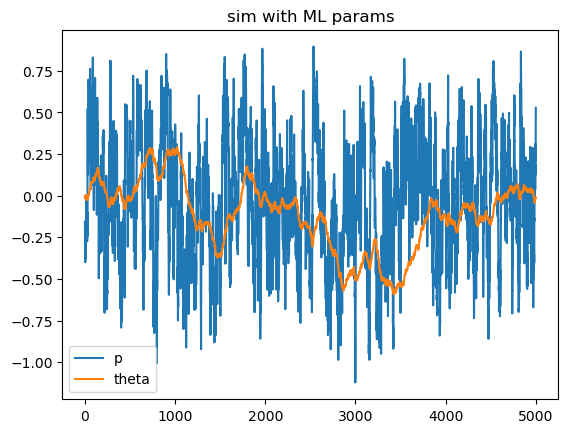

In [15]:
for s in sims: 
    plt.plot(s[1], label='p')
    plt.plot(s[0], label='theta')
    plt.legend()
    plt.title('sim with ML params')
    plt.show() 

In [22]:
MAP2, y2 = inf.inf(MAP, sims, dt, bounds=bounds)
print(MAP, inf._minuslogP(MAP, sims, dt))
print(MAP2, y2)

[  0.046   1.413   0.169   5.894 801.784   0.026   0.744] -161824.91780291742
[  0.041   1.302   0.144   7.232 888.719   0.025   0.678] -162161.33174217294


(51936.358839846594+34524.73630315592j)


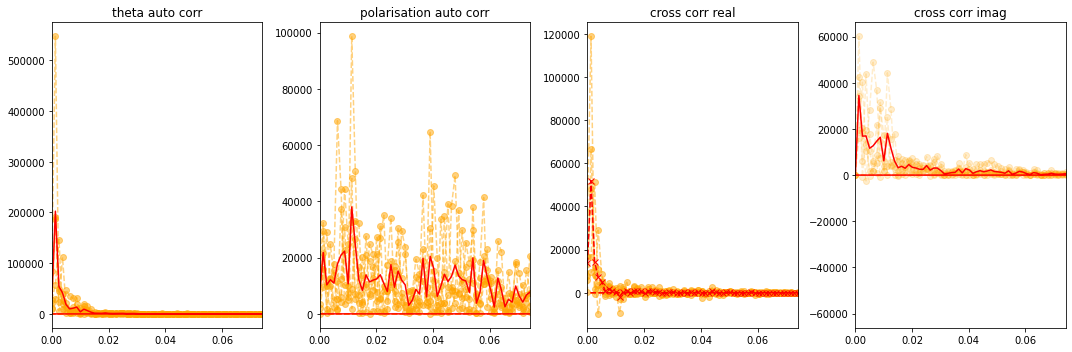

In [42]:
fig, axs = plt.subplots(1, 4, sharex=True, figsize=(15, 5))
L = n_frames
sims = np.array(sims)
thetas = sims[:, 0, :]
ps = sims[:, 1, :]

omegas = np.fft.fftfreq(L)*2*np.pi

for (theta, p) in sims:
    theta_omega = np.fft.fft(theta)
    p_omega = np.fft.fft(p)
    theta_corr = np.abs(theta_omega)**2
    p_corr = np.abs(p_omega)**2
    cross_corr = np.conj(theta_omega)*p_omega
    
    axs[0].plot(omegas, theta_corr, 'o--', alpha=0.5, color='orange')
    axs[1].plot(omegas, p_corr, 'o--', alpha=0.5, color='orange')
    axs[2].plot(omegas, cross_corr.real, 'o--', alpha=0.5, color='orange')
    axs[3].plot(omegas, cross_corr.imag, 'o--', alpha=0.2, color='orange')


theta_corr = np.mean(np.abs(np.fft.fft(thetas))**2, axis=0)
axs[0].plot(omegas, theta_corr, color='red')
axs[0].set_title('theta auto corr')


p_corr = np.mean(np.abs(np.fft.fft(ps))**2, axis=0)
axs[1].plot(omegas, p_corr, color='red')
axs[1].set_title('polarisation auto corr')

cross_corr = np.mean(np.conjugate(np.fft.fft(thetas))*np.fft.fft(ps), axis=0)
axs[2].plot(omegas, cross_corr.real, 'x--', color='red')

axs[2].set_title('cross corr real')
axs[3].plot(omegas, cross_corr.imag, color='red')
axs[3].set_title('cross corr imag')

print(cross_corr[1])


axs[0].set_xlim([0, max(omegas[:60])])
plt.tight_layout()
plt.show()  